## Imports

In [15]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Download Data

In [16]:
MONTHS = 36

# Define weights (original fund tickers)
weights = {
    "AUTO.OL": 0.019094, "BKW.SW": 0.050846, "BMI": 0.033615, "CGNX": 0.028368, "CLH": 0.038201,
    "CWST": 0.047824, "CWY.AX": 0.038031, "ECL": 0.054767, "ENEL.MI": 0.063910, "ENR.DE": 0.023263,
    "FSLR": 0.019741, "GF.SW": 0.035485, "GFL": 0.038149, "GXO": 0.028886, "IBE.MC": 0.066922,
    "KGX.DE": 0.029591, "MANH": 0.032971, "NEE": 0.040971, "ORSTED.CO": 0.028671, "SYM": 0.011842,
    "TOM.OL": 0.019474, "VIE.PA": 0.055726, "VLTO": 0.053097, "WM": 0.057568, "XYL": 0.048435, "ZBRA": 0.034552
}

weights = pd.Series(weights)

# Define time range
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(months=MONTHS)

# Benchmark tickers
benchmark_tickers = ["^GSPC", "^SSMI", "^DJI"]
basket_tickers = list(weights.index)
all_tickers = basket_tickers + benchmark_tickers

# Download data
print(f"Downloading {MONTHS} months of data...")
data = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)


## Clean Up Data

- We are (currently) only interested in close
- Deal with yfinance api...
- Linear interpolation between missing values
- Drop sparse data

In [17]:
# Handle multi-index if present (yfinance...)

if isinstance(data.columns, pd.MultiIndex):
    if 'Close' in data.columns.levels[0]:
        data = data['Close']
    elif 'Adj Close' in data.columns.levels[0]:
        data = data['Adj Close']
    else:
        try:
            data.columns = data.columns.droplevel(0)
        except:
            price_cols = [col for col in data.columns if col[0] in ['Close', 'Adj Close']]
            if price_cols:
                data = data[price_cols]
                data.columns = data.columns.droplevel(0)
            else:
                data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Flatten remaining multi-index if needed
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(0)
elif any(isinstance(col, tuple) for col in data.columns):
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Interpolate and drop sparsely populated rows/columns
print("Interpolating and cleaning data...")
data = data.interpolate(method="linear")
data = data.dropna(axis=0, thresh=int(0.7 * len(data.columns)))
data = data.dropna(axis=1, thresh=int(0.7 * len(data)))

# Keep only tickers with valid data
benchmark_tickers = [t for t in benchmark_tickers if t in data.columns]
valid_tickers = data.columns.drop(benchmark_tickers, errors='ignore')
valid_weights = weights[weights.index.isin(valid_tickers)]

if valid_weights.empty:
    raise ValueError("No valid tickers found after cleaning.")

# Re-normalize weights after cleaning
valid_weights = valid_weights / valid_weights.sum()

print("Final tickers:", list(valid_weights.index))
print("Final benchmark tickers:", benchmark_tickers)
print("Data cleaned and ready.")


Interpolating and cleaning data...
Final tickers: ['AUTO.OL', 'BKW.SW', 'BMI', 'CGNX', 'CLH', 'CWST', 'CWY.AX', 'ECL', 'ENEL.MI', 'ENR.DE', 'FSLR', 'GF.SW', 'GFL', 'GXO', 'IBE.MC', 'KGX.DE', 'MANH', 'NEE', 'ORSTED.CO', 'SYM', 'TOM.OL', 'VIE.PA', 'WM', 'XYL', 'ZBRA']
Final benchmark tickers: ['^GSPC', '^SSMI', '^DJI']
Data cleaned and ready.


## Normalize Basket

In [18]:
# Normalize Basket (Fund) to 100 at the start of the period
normalized_basket = data[valid_weights.index].divide(data[valid_weights.index].iloc[0]) * 100
basket_index = normalized_basket.multiply(valid_weights, axis=1).sum(axis=1)

# Normalize Benchmarks (S&P 500, SMI, DJ) to 100 at the start of the period
normalized_benchmarks = {}
for ticker in benchmark_tickers:
    if ticker in data:
        normalized_benchmarks[ticker] = data[ticker] / data[ticker].iloc[0] * 100
        print(f"Benchmark {ticker} normalized.")
    else:
        print(f"Benchmark ticker {ticker} not found in data after cleaning.")


Benchmark ^GSPC normalized.
Benchmark ^SSMI normalized.
Benchmark ^DJI normalized.


## Plots

### Basket vs Benchmarks

We look at normalized returns and compare our basket to the benchmarks (S&P500, Dow Jones, SMI).

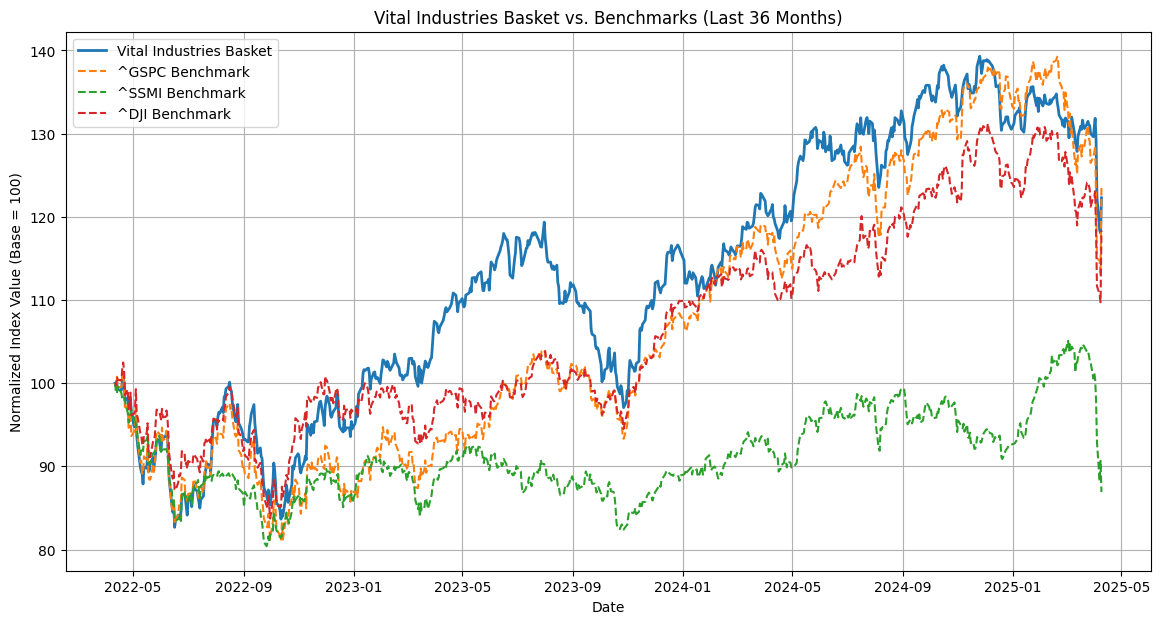

In [19]:
# Plotting the basket index and benchmarks
plt.figure(figsize=(14, 7))
plt.plot(basket_index, label='Vital Industries Basket', linewidth=2)

# Plot each benchmark
for ticker, normalized_benchmark in normalized_benchmarks.items():
    plt.plot(normalized_benchmark, label=f'{ticker} Benchmark', linestyle='--')

# Labels, title, and legend
plt.title(f'Vital Industries Basket vs. Benchmarks (Last {MONTHS} Months)')
plt.xlabel('Date')
plt.ylabel('Normalized Index Value (Base = 100)')
plt.legend()
plt.grid(True)
plt.show()


### Correlation: Basket vs Benchmarks

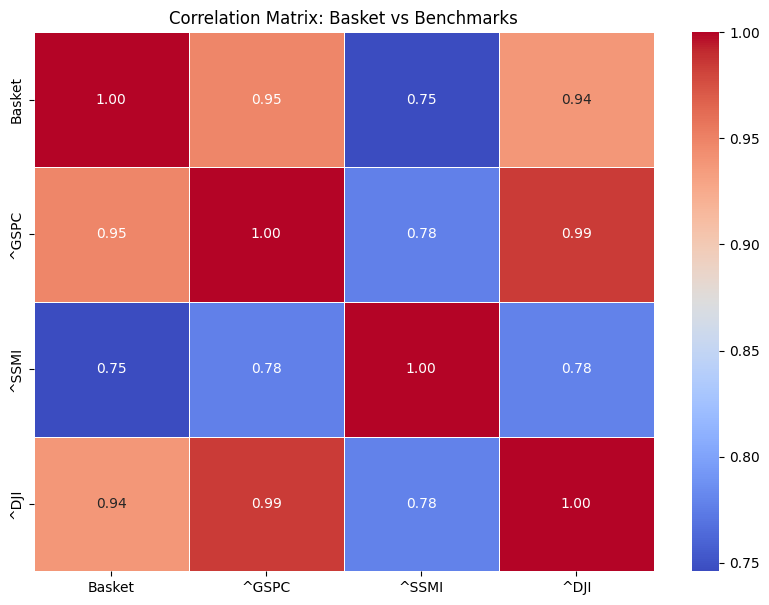

In [20]:
# Combine all data (basket + benchmarks) for correlation analysis
combined_data = pd.concat([basket_index] + list(normalized_benchmarks.values()), axis=1)
combined_data.columns = ['Basket'] + [ticker for ticker in benchmark_tickers]

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Plotting correlation matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix: Basket vs Benchmarks')
plt.show()


### Calculate BETA

Beta for ^GSPC: 0.70
Beta for ^SSMI: 0.67
Beta for ^DJI: 0.80


/tmp/ipykernel_1066425/2076484095.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Beta is the slope of the regression line
/tmp/ipykernel_1066425/2076484095.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Beta is the slope of the regression line
/tmp/ipykernel_1066425/2076484095.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Beta is the slope 

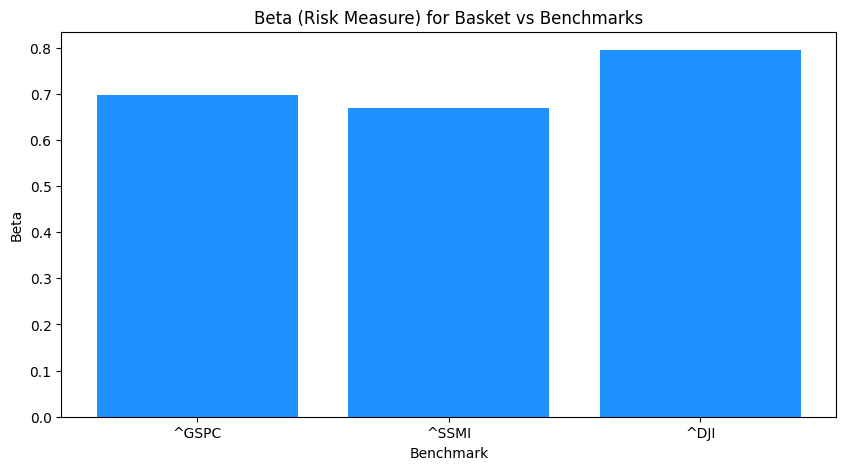

In [21]:
def calculate_beta(basket_returns, benchmark_returns):
    # Use linear regression to calculate beta (slope of regression)
    model = sm.OLS(basket_returns, sm.add_constant(benchmark_returns)).fit()
    return model.params[1]  # Beta is the slope of the regression line

# Calculate Beta for each benchmark
betas = {}
for ticker, normalized_benchmark in normalized_benchmarks.items():
    # Calculate the returns for both basket and benchmark
    basket_returns = basket_index.pct_change().dropna()
    benchmark_returns = normalized_benchmark.pct_change().dropna()

    # Align the data
    aligned_data = pd.concat([basket_returns, benchmark_returns], axis=1).dropna()
    basket_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # Calculate Beta
    beta = calculate_beta(basket_returns, benchmark_returns)
    betas[ticker] = beta
    print(f"Beta for {ticker}: {beta:.2f}")

# Plotting Beta Comparison
plt.figure(figsize=(10, 5))
plt.bar(betas.keys(), betas.values(), color='dodgerblue')
plt.title('Beta (Risk Measure) for Basket vs Benchmarks')
plt.xlabel('Benchmark')
plt.ylabel('Beta')
plt.show()

### Calculate ALPHA

Alpha for ^GSPC: 0.0001
Alpha for ^SSMI: 0.0004
Alpha for ^DJI: 0.0001


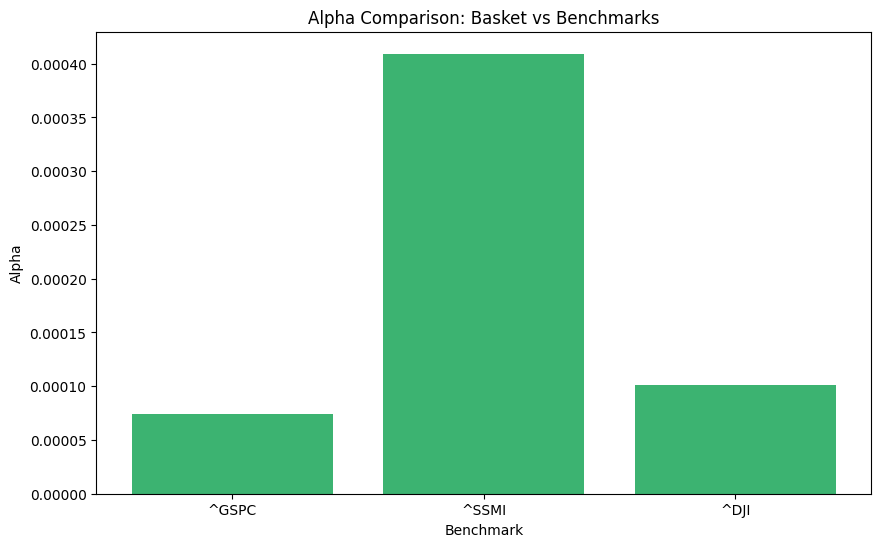

In [22]:
# Set the risk-free rate to 0 for simplicity (as no specific risk-free rate was given)
risk_free_rate = 0

def calculate_alpha(basket_returns, benchmark_returns, beta):
    # Excess returns (benchmark returns minus risk-free rate)
    excess_benchmark_returns = benchmark_returns - risk_free_rate
    # Calculate Alpha (intercept of regression model)
    alpha = basket_returns.mean() - (beta * excess_benchmark_returns.mean())
    return alpha

# Calculate Alpha for the Basket against each benchmark
alpha_values = {}

for ticker, normalized_benchmark in normalized_benchmarks.items():
    # Calculate the returns for both basket and benchmark
    basket_returns = basket_index.pct_change().dropna()
    benchmark_returns = normalized_benchmark.pct_change().dropna()

    # Align the data
    aligned_data = pd.concat([basket_returns, benchmark_returns], axis=1).dropna()
    basket_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]

    # Calculate Beta (we'll use previously calculated beta)
    beta = betas[ticker]
    
    # Calculate Alpha
    alpha = calculate_alpha(basket_returns, benchmark_returns, beta)
    alpha_values[ticker] = alpha
    print(f"Alpha for {ticker}: {alpha:.4f}")

# Plotting Alpha Comparison
plt.figure(figsize=(10, 6))
plt.bar(alpha_values.keys(), alpha_values.values(), color='mediumseagreen')
plt.title('Alpha Comparison: Basket vs Benchmarks')
plt.xlabel('Benchmark')
plt.ylabel('Alpha')
plt.show()


### Calculate Sharpe Ratio

/tmp/ipykernel_1066425/3555806409.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['Sharpe Ratio'], palette='Blues')


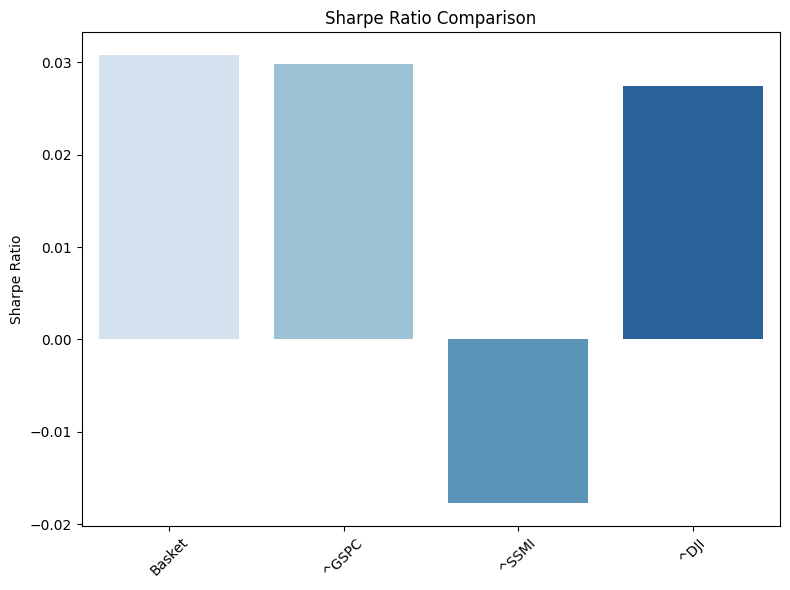

In [23]:
# Define a function to calculate the Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

basket_sharpe = sharpe_ratio(basket_returns)



benchmark_sharpe = {}

for ticker, normalized_benchmark in normalized_benchmarks.items():
    benchmark_returns = normalized_benchmark.pct_change().dropna()
    benchmark_sharpe[ticker] = sharpe_ratio(benchmark_returns)

# --- STEP 16.3: Create a DataFrame for Comparison ---
metrics = {
    'Sharpe Ratio': [basket_sharpe] + list(benchmark_sharpe.values()),
}

# Convert to DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics, index=['Basket'] + list(benchmark_tickers))

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Sharpe Ratio'], palette='Blues')
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Stock Contribution to Basket Returns

/tmp/ipykernel_1066425/166896778.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contribution_to_pnl.index, y=contribution_to_pnl.values, palette=colors)


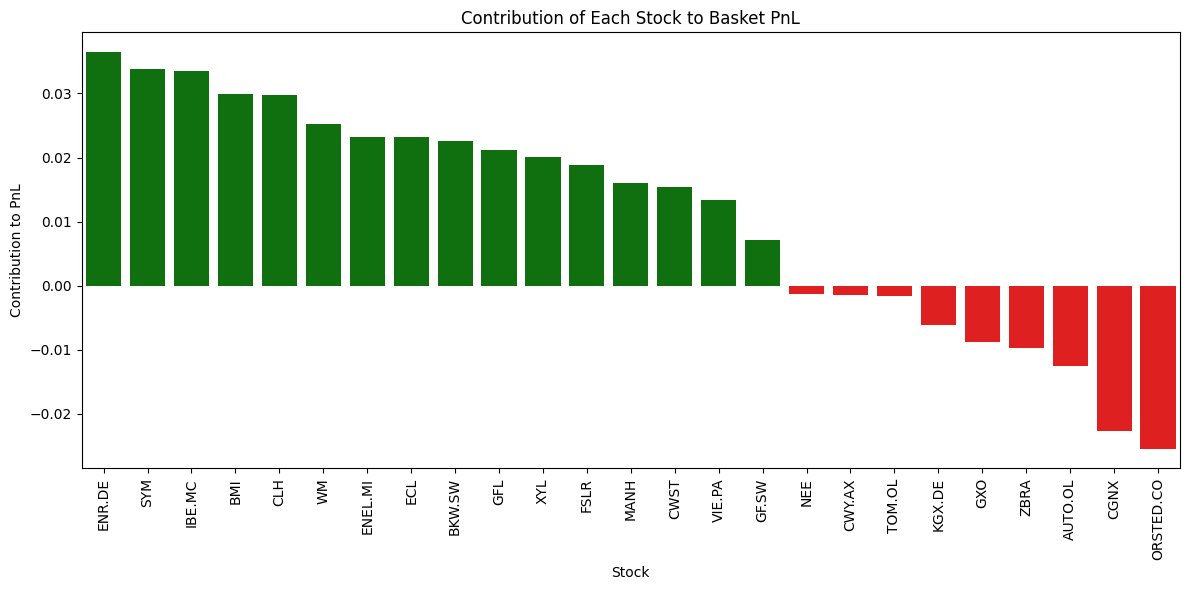

Ticker
ENR.DE       0.036445
SYM          0.033743
IBE.MC       0.033554
BMI          0.029947
CLH          0.029785
WM           0.025248
ENEL.MI      0.023177
ECL          0.023142
BKW.SW       0.022534
GFL          0.021218
XYL          0.020034
FSLR         0.018762
MANH         0.016020
CWST         0.015381
VIE.PA       0.013451
GF.SW        0.007114
NEE         -0.001313
CWY.AX      -0.001472
TOM.OL      -0.001554
KGX.DE      -0.006059
GXO         -0.008737
ZBRA        -0.009668
AUTO.OL     -0.012573
CGNX        -0.022700
ORSTED.CO   -0.025412
Name: 2025-04-09 00:00:00, dtype: float64

In [24]:
# Calculate daily returns for each stock in the basket
basket_data = data[valid_weights.index]
daily_returns = basket_data.pct_change().dropna()

# Calculate the weighted return for each stock
weighted_returns = daily_returns.multiply(valid_weights, axis=1)

# Calculate the cumulative return for each stock's contribution
cumulative_contribution = (1 + weighted_returns).cumprod()

# Calculate the overall cumulative return for the basket
basket_cumulative_return = (1 + basket_returns).cumprod()

# Calculate the total contribution from each stock to the basket
contribution_to_pnl = cumulative_contribution.iloc[-1] - 1

# Show the contribution of each stock
contribution_to_pnl = contribution_to_pnl.sort_values(ascending=False)


# Create color array based on whether the contribution is positive or negative
colors = ['green' if x >= 0 else 'red' for x in contribution_to_pnl.values]

# Plot the contribution of each stock to the basket PnL
plt.figure(figsize=(12, 6))
sns.barplot(x=contribution_to_pnl.index, y=contribution_to_pnl.values, palette=colors)
plt.title('Contribution of Each Stock to Basket PnL')
plt.xlabel('Stock')
plt.ylabel('Contribution to PnL')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display the contribution data
contribution_to_pnl


### Monte Carlo Simulation

Includes confidence levels up to 3-sigma.

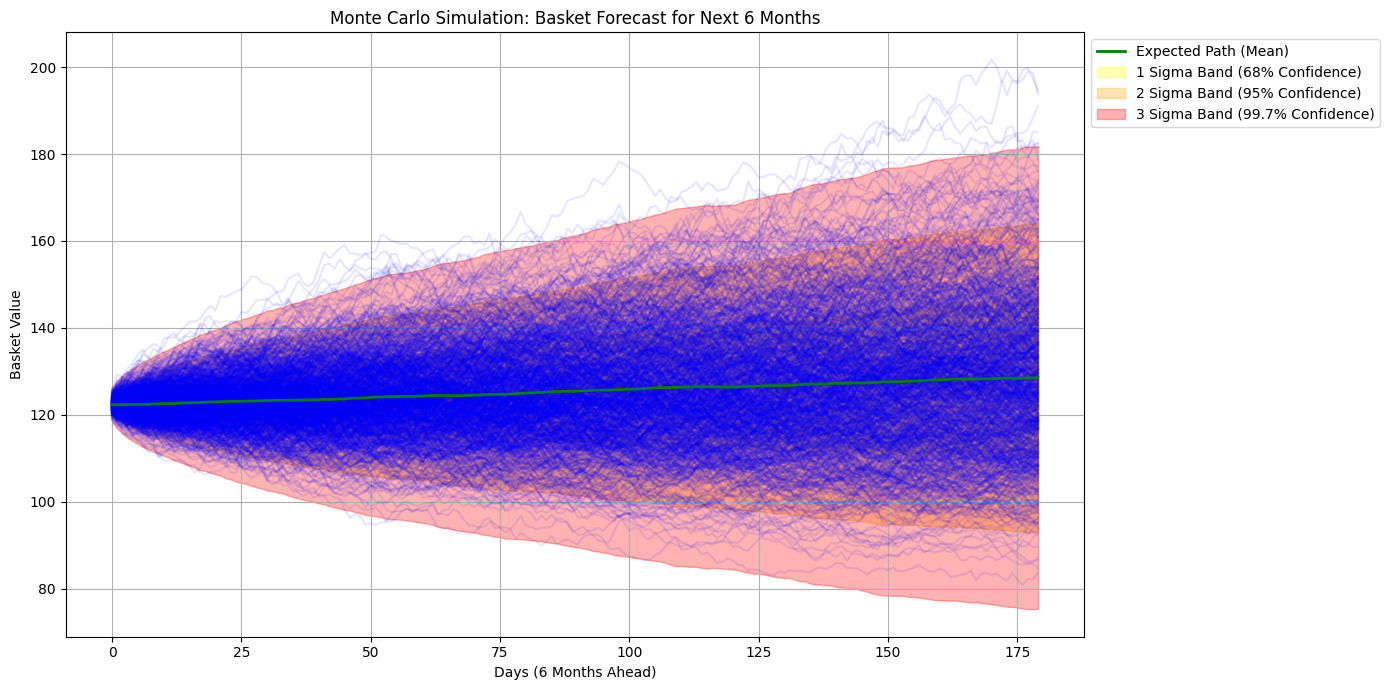

In [25]:
# Parameters for the Monte Carlo Simulation
n_simulations = 1000  # Number of simulations
n_months = 6
n_days = int(360/12 * n_months)
initial_value = basket_index.iloc[-1]  # The latest value of the basket

# Historical returns and volatility (daily)
historical_returns = basket_returns.mean()
historical_volatility = basket_returns.std()

# Initialize the results array
simulated_paths = np.zeros((n_simulations, n_days))

# Monte Carlo Simulation: Generate potential future paths
for i in range(n_simulations):
    daily_returns_simulated = np.random.normal(historical_returns, historical_volatility, n_days)
    cumulative_returns = np.cumprod(1 + daily_returns_simulated)
    simulated_paths[i, :] = initial_value * cumulative_returns

# Calculate the 1-sigma, 2-sigma, and 3-sigma bands
simulated_mean = simulated_paths.mean(axis=0)
simulated_1sigma = simulated_paths.std(axis=0)
simulated_2sigma = 2 * simulated_1sigma
simulated_3sigma = 3 * simulated_1sigma

# Plot the Monte Carlo simulations with confidence bands
plt.figure(figsize=(14, 7))

# Plot all the simulated paths
for i in range(n_simulations):
    plt.plot(simulated_paths[i, :], color='blue', alpha=0.1)  # All individual paths

# Plot the mean path (expected path)
plt.plot(simulated_mean, color='green', label='Expected Path (Mean)', linewidth=2)

# Plot the 1-sigma, 2-sigma, and 3-sigma bands
plt.fill_between(range(n_days), simulated_mean - simulated_1sigma, simulated_mean + simulated_1sigma, 
                 color='yellow', alpha=0.3, label='1 Sigma Band (68% Confidence)')
plt.fill_between(range(n_days), simulated_mean - simulated_2sigma, simulated_mean + simulated_2sigma, 
                 color='orange', alpha=0.3, label='2 Sigma Band (95% Confidence)')
plt.fill_between(range(n_days), simulated_mean - simulated_3sigma, simulated_mean + simulated_3sigma, 
                 color='red', alpha=0.3, label='3 Sigma Band (99.7% Confidence)')

# Add labels and legend
plt.title(f'Monte Carlo Simulation: Basket Forecast for Next {n_months} Months')
plt.xlabel(f'Days ({n_months} Months Ahead)')
plt.ylabel('Basket Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


### Cummulative Stock Contribution

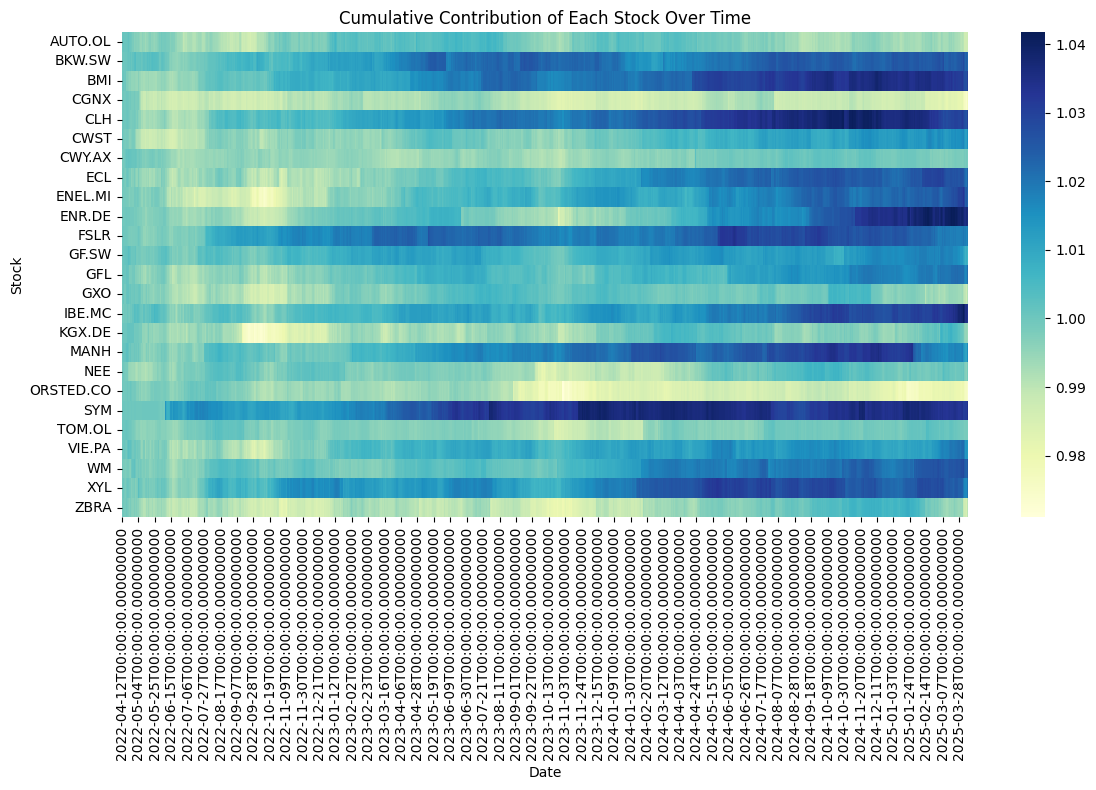

In [26]:
# Calculate cumulative contribution for each stock over time
cumulative_contribution = (1 + weighted_returns).cumprod()

# Plot the heatmap of cumulative contributions
plt.figure(figsize=(12, 8))
sns.heatmap(cumulative_contribution.T, cmap="YlGnBu", annot=False, fmt='.1f', cbar=True)
plt.title('Cumulative Contribution of Each Stock Over Time')
plt.xlabel('Date')
plt.ylabel('Stock')
plt.tight_layout()
plt.show()


### Basket vs Stocks

/tmp/ipykernel_1066425/3845753472.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=excess_returns.index, y=excess_returns.values, palette='coolwarm')


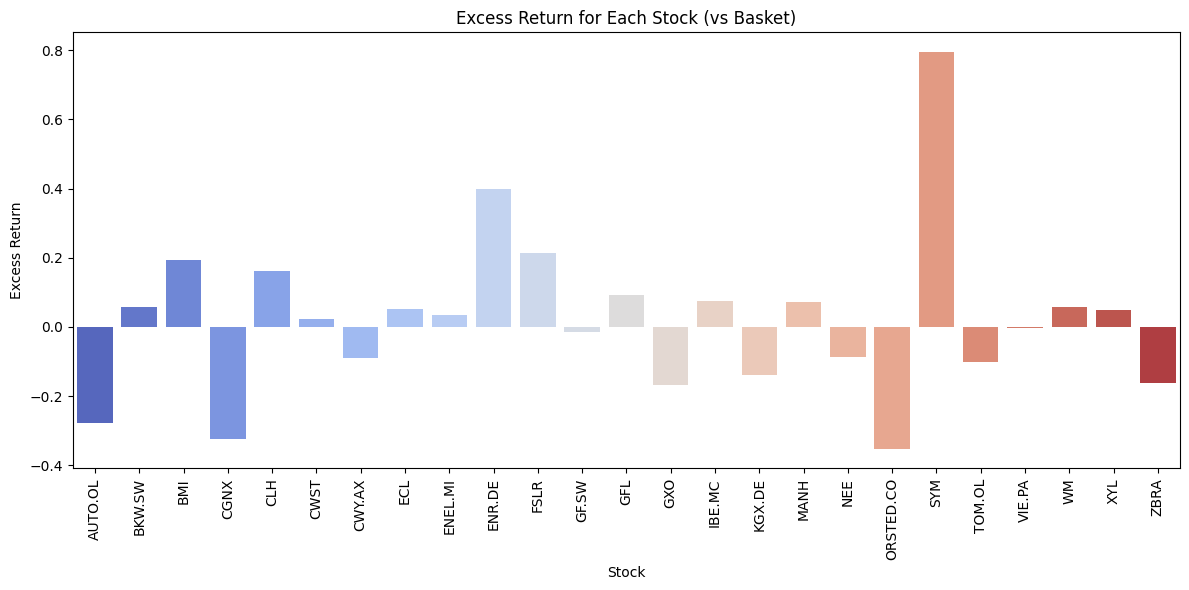

In [27]:
# Calculate the excess return for each stock (difference between stock return and basket return)
stock_returns = daily_returns.mean() * 252  # Annualized returns
excess_returns = stock_returns - basket_returns.mean() * 252  # Annualized excess return

# Plot the excess return for each stock
plt.figure(figsize=(12, 6))
sns.barplot(x=excess_returns.index, y=excess_returns.values, palette='coolwarm')
plt.title('Excess Return for Each Stock (vs Basket)')
plt.xlabel('Stock')
plt.ylabel('Excess Return')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
